# Machine Learning Fundamentals

Today we will implement two simple content-based recommender systems. During the semester we will have a lecture on recommender systems where we look in depth about content-based and collaborative filtering recommender systems.

The main goal of this exercise is to get an understanding why similarities and normalization are very important for Machine Learning. 

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import skimage
import skimage.io

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

from tqdm.notebook import tqdm
import ipywidgets as widgets

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

%matplotlib inline

## Exercise 1 - Simple recommender system for AutoScout based on KNN
AutoScout24 provided us with a dump of their productive database. You are assigned to implement a recommender system that will suggest you an adequate car based on your preferences.

<a href="https://www.autoscout24.ch/de"><img src="https://www.autoscout24.ch/MVC/Content/desktop/img/autoscout24-logo-og.png" height="30%" width="30%"/></a>

### Prepare Data

In [2]:
df = pd.read_csv("cars_image.csv")
df.head()

,Name,Price,Mileage,Doors,Horsepower,Seats,Year,Cabriolet,Black,ImageId
0,MERCEDES-BENZ SL 500,44800,27600,2,320,2,1996,True,False,926290cb-c1f2-4c49-8811-ab561f609e30
1,MERCEDES-BENZ SL 600,69800,12900,2,394,2,1996,True,False,e2dad305-d0f5-4ef5-9061-3282cb992a51
2,BMW 740iL,22800,18300,4,286,5,1999,False,False,51d42968-fa2f-495e-90a3-a2c222d6d350
3,MERCEDES-BENZ SL 320,44800,25100,2,224,2,2000,True,False,776381f0-fa48-4075-ae13-809e718cd96f
4,PORSCHE 911 GT2,199800,300,2,462,4,2004,False,True,d371d7a4-97ef-4850-a6e9-52fb5669bcae


We select 3 cars from our dataset and take the rest as our training set. We are only interested in some of the features.

In [3]:
test_idx = [156, 233, 203]
test_idx = df.index.isin(test_idx)

test = df[test_idx]
train = df[~test_idx]

test.reset_index(inplace=True)
test = test.drop(columns=["index"])

features = ["Price", "Mileage", "Doors", "Horsepower", "Seats", "Year", "Cabriolet", "Black"]
X_train = train[features]
X_test = test[features]
X_test.head()

,Price,Mileage,Doors,Horsepower,Seats,Year,Cabriolet,Black
0,12800,12920,2,147,4,2003,True,False
1,14950,50000,2,150,4,2002,False,False
2,10600,110000,2,100,4,1999,True,True


We implement a function that displays a given car.

In [4]:
def display_car(car, ax=None):
    img_id = car.ImageId.values[0]
    img_path = "images/{}.jpg".format(img_id)
    img = skimage.io.imread(img_path)
    
    if ax is None:
        fig, ax = plt.subplots(1)
    ax.set_title("car {} - {}".format(car.index.values[0], car.Name.values[0]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img)

    car_features = car[features]
    display(car_features)

Let's try it by sampling a car from our dataset.

,Price,Mileage,Doors,Horsepower,Seats,Year,Cabriolet,Black
278,99800,32500,2,500,2,2003,True,False


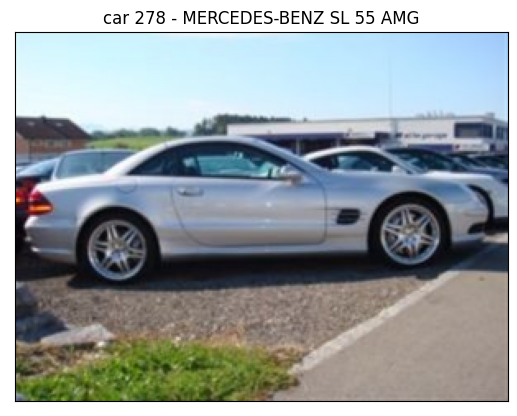

In [5]:
car = df.sample(1)
display_car(car)

### Display test data
Let us now display our test cars.

,Price,Mileage,Doors,Horsepower,Seats,Year,Cabriolet,Black
0,12800,12920,2,147,4,2003,True,False


,Price,Mileage,Doors,Horsepower,Seats,Year,Cabriolet,Black
1,14950,50000,2,150,4,2002,False,False


,Price,Mileage,Doors,Horsepower,Seats,Year,Cabriolet,Black
2,10600,110000,2,100,4,1999,True,True


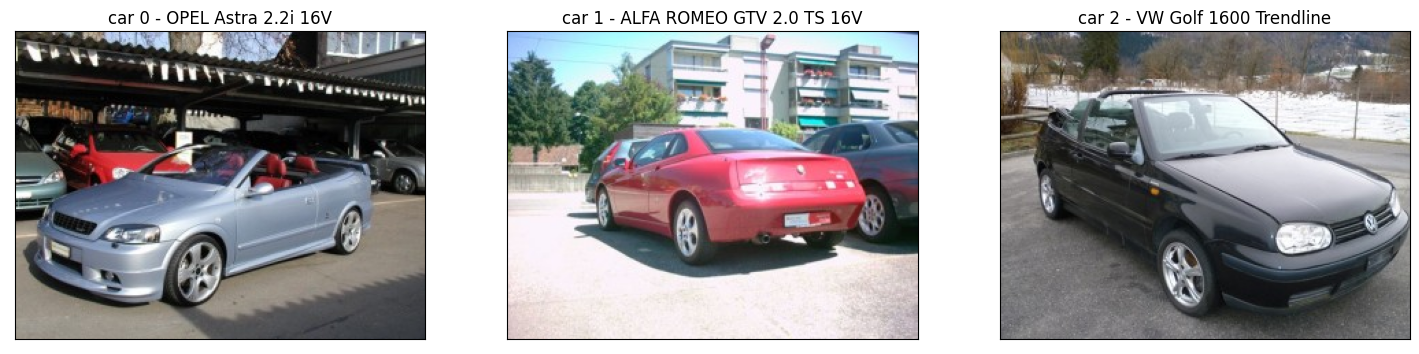

In [6]:
car0 = test.iloc[[0]]
X_car0 = X_test.values[0]

car1 = test.iloc[[1]]
X_car1 = X_test.values[1]

car2 = test.iloc[[2]]
X_car2 = X_test.values[2]

fig, ax = plt.subplots(1, 3, figsize=(18,12))

display_car(car0, ax[0])
display_car(car1, ax[1])
display_car(car2, ax[2])

We want to know whether car 1 or car 2 is more similar to car 0. We need to somehow measure the distance between the cars.

In [7]:
X_test.head()

,Price,Mileage,Doors,Horsepower,Seats,Year,Cabriolet,Black
0,12800,12920,2,147,4,2003,True,False
1,14950,50000,2,150,4,2002,False,False
2,10600,110000,2,100,4,1999,True,True


### Implementing distance measures
To implement our recommender system, we need a measure that tells us how large the difference between to cars is.

#### Euclidean Distance

Implement the euclidean distance measure

In [8]:
def euclidean_distance(v1, v2):
    return np.sqrt(np.sum((v1 - v2) ** 2))
    ## or:
    ## return np.linalg.norm(v1 - v2)
    ## return scipy.spatial.distance.euclidean(v1, v2)

In [9]:
print("Distance between car 0 and car 1 = ", euclidean_distance(X_car0, X_car1))
print("Distance between car 0 and car 2 = ", euclidean_distance(X_car0, X_car2))

Distance between car 0 and car 1 =  37142.279291933606
Distance between car 0 and car 2 =  97104.93615671656


The euclidean distance between car 0 and car 1 is smaller than between car 0 and car 2, i.e. car 0 and car 1 are more similar.

#### Cosine distance

We now implement another distance measure, the cosine similarity.
Implement the cosine similarity

In [10]:
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

Now we have implemented the cosine similarity. However we want the *cosine distance*.

In [11]:
def cosine_distance(v1, v2):
    return 1 - cosine_similarity(v1, v2)

In [12]:
print("Distance between car 0 and car 1 = ", cosine_distance(X_car0, X_car1))
print("Distance between car 0 and car 2 = ", cosine_distance(X_car0, X_car2))

Distance between car 0 and car 1 =  0.11951764129513875
Distance between car 0 and car 2 =  0.22818901454479357


The cosine similarity tells us again that car 0 and car 1 are more similar than car 0 and car 2.

### Find most similar car
Let's find the most similar car in our training set.

Implement the function `get_nearest_neighbor` which returns the minimum distance and the index of the most similar car. The argument `distance` represents the distance function (either `euclidean_distance` or `cosine_distance`).

In [13]:
def get_nearest_neighbor(source_car, cars, distance):
    # START YOUR CODE
    similarities = np.array([distance(source_car, car) for car in tqdm(cars)])
    distance = np.min(similarities)
    idx = np.argmin(similarities)

    # END YOUR CODE
    return distance, idx

#### Testing our function

,Price,Mileage,Doors,Horsepower,Seats,Year,Cabriolet,Black
0,12800,12920,2,147,4,2003,True,False


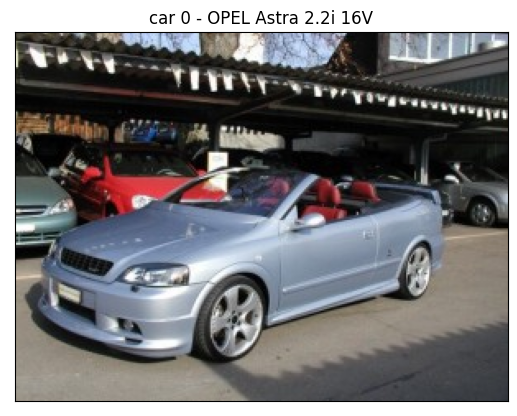

In [14]:
display_car(car0)

Let's test our nearest neighbor function by using the cosine distance. We want to know the most similar car to our test car `car0`.

  0%|          | 0/1997 [00:00<?, ?it/s]

1118
0.00015247852690991603


,Price,Mileage,Doors,Horsepower,Seats,Year,Cabriolet,Black
0,12800,12920,2,147,4,2003,True,False


,Price,Mileage,Doors,Horsepower,Seats,Year,Cabriolet,Black
1121,13900,13600,3,69,4,2010,False,False


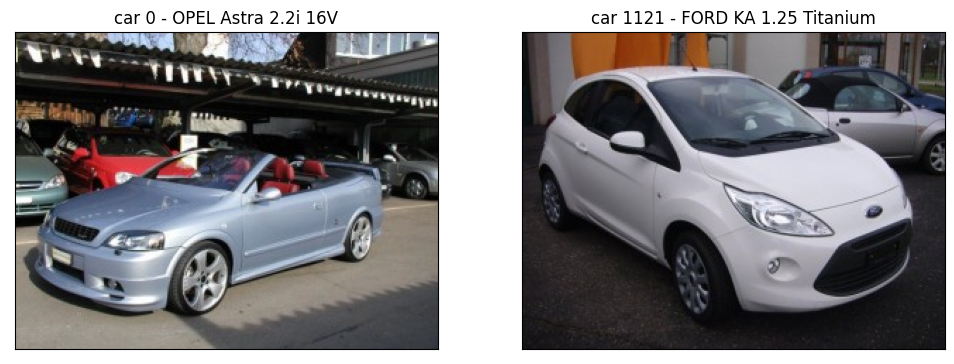

In [15]:
distance, idx = get_nearest_neighbor(X_car0, X_train.values, cosine_distance)
print(idx)
print(distance)

most_similar_car = train.iloc[[idx]]

fig, ax = plt.subplots(1, 2, figsize=(12,12))
display_car(car0, ax[0])
display_car(most_similar_car, ax[1])

The price and the mileage are quite similar. However it is definitely not a cabriolet and the number of doors are far from our car.

Let's check if the recommendation with the euclidean distance measure looks better.

  0%|          | 0/1997 [00:00<?, ?it/s]

1118
1295.5828804055725


,Price,Mileage,Doors,Horsepower,Seats,Year,Cabriolet,Black
0,12800,12920,2,147,4,2003,True,False


,Price,Mileage,Doors,Horsepower,Seats,Year,Cabriolet,Black
1121,13900,13600,3,69,4,2010,False,False


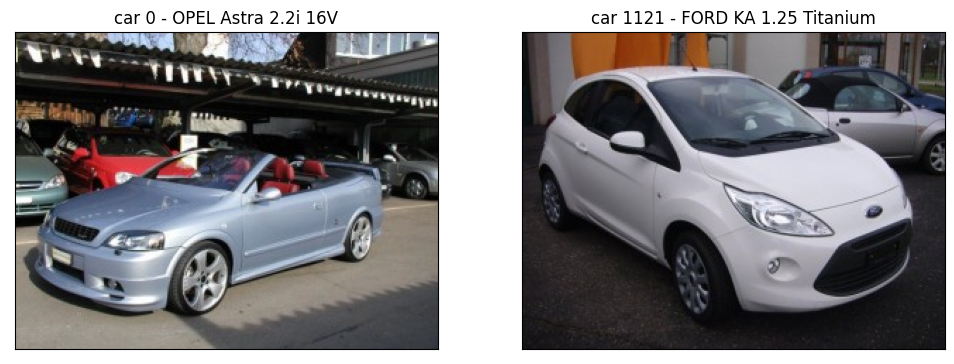

In [16]:
distance, idx = get_nearest_neighbor(X_car0, X_train.values, euclidean_distance)
print(idx)
print(distance)

most_similar_car = train.iloc[[idx]]

fig, ax = plt.subplots(1, 2, figsize=(12,12))
display_car(car0, ax[0])
display_car(most_similar_car, ax[1])

We still get a bad recommendation.

### Normalize the data
We forgot to normalize our training data! Let's do that and check if our recommendation is looks now better.

In [17]:
scaler = MinMaxScaler()

# we reuse the same scaler twice
# the first time we have to fit and transform it
# the second time we can use transform on its own because it's already fitted
X_train_transform = scaler.fit_transform(X_train)
X_car0_transform = scaler.transform([X_car0])

  0%|          | 0/1997 [00:00<?, ?it/s]

687
0.06190906206393911


,Price,Mileage,Doors,Horsepower,Seats,Year,Cabriolet,Black
0,12800,12920,2,147,4,2003,True,False


,Price,Mileage,Doors,Horsepower,Seats,Year,Cabriolet,Black
690,15800,31000,2,147,4,2003,True,False


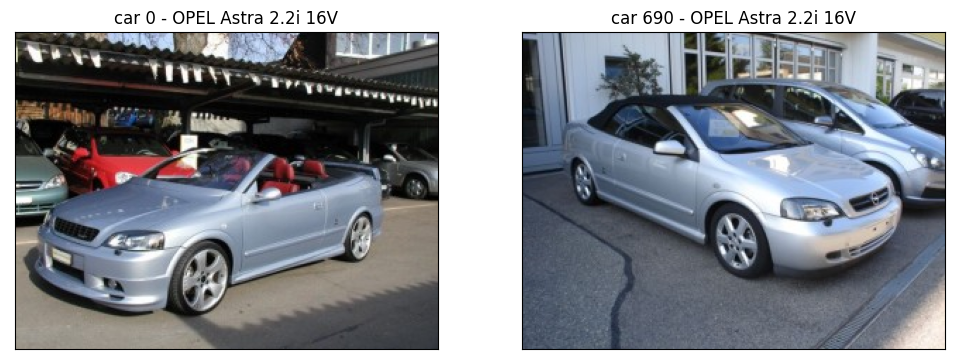

In [18]:
distance, idx = get_nearest_neighbor(X_car0_transform, X_train_transform, euclidean_distance)
print(idx)
print(distance)

most_similar_car = train.iloc[[idx]]

fig, ax = plt.subplots(1, 2, figsize=(12,12))
display_car(car0, ax[0])
display_car(most_similar_car, ax[1])

Wow, we now get a perfect match.

### Use Nearest Neighbor implementation from Scikit-Learn

Let's move to the Scikit-Learn implementation [NearestNeighbors](https://scikit-learn.org/stable/modules/neighbors.html) and check if we get the same result.

In [19]:
knn = NearestNeighbors(n_neighbors=1, metric="euclidean")
knn.fit(X_train_transform)

NearestNeighbors(metric='euclidean', n_neighbors=1)

,Price,Mileage,Doors,Horsepower,Seats,Year,Cabriolet,Black
0,12800,12920,2,147,4,2003,True,False


,Price,Mileage,Doors,Horsepower,Seats,Year,Cabriolet,Black
690,15800,31000,2,147,4,2003,True,False


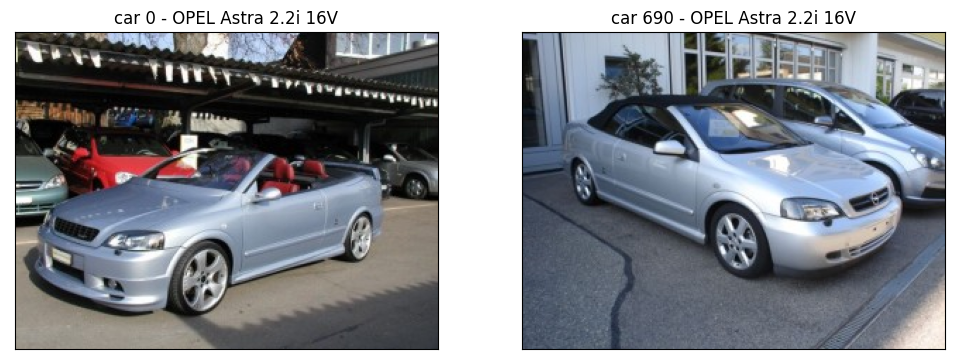

In [20]:
distance, idx = knn.kneighbors(X_car0_transform)

most_similar_car = train.iloc[idx[0]]

fig, ax = plt.subplots(1, 2, figsize=(12,12))
display_car(car0, ax[0])
display_car(most_similar_car, ax[1])

The result looks the same with the Scikit-Learn implementation.

### Build a recommender system

We can build now our own recommender system. 
>Play around with our recommender system.

In [21]:
@widgets.interact(price=widgets.FloatText(value=15000), 
                  mileage=widgets.IntText(value=20000), 
                  doors=widgets.Dropdown(options=sorted(df.Doors.unique())), 
                  horsepower=widgets.IntText(value=100), 
                  seats=widgets.Dropdown(options=sorted(df.Seats.unique()), value=2), 
                  year=widgets.IntText(value=2010),
                  cabriolet=widgets.Dropdown(options=[("Yes", True), ("No", False)]),
                  black=widgets.Dropdown(options=[("Yes", True), ("No", False)]))
def recommend(price, mileage, doors, horsepower, seats, year, cabriolet, black):
    car = np.array([[price, mileage, doors, horsepower, seats, year, cabriolet, black]])
    car = scaler.transform(car)
    
    pred = knn.kneighbors(car)
    idx = pred[1][0]
    
    most_similar_car = train.iloc[idx]
    display_car(most_similar_car)

interactive(children=(FloatText(value=15000.0, description='price'), IntText(value=20000, description='mileage…

In [22]:
@widgets.interact(name=widgets.Dropdown(options=sorted(df.Name.unique())))
def recommend(name):
    car = df.loc[df.Name == name]
    car = car[features].values
    car = scaler.transform(car)
    
    pred = knn.kneighbors(car)
    idx = pred[1][0]
    
    most_similar_car = train.iloc[idx]
    display_car(most_similar_car)

interactive(children=(Dropdown(description='name', options=('ALFA ROMEO 147 1.6 16V Distinctive', 'ALFA ROMEO …